In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

In [116]:
# Import metrics

metrics = pd.read_csv("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/model_metrics.csv")
metrics.drop([2,5], inplace = True) # Drops row with index 2 and 5, as I forgot to write header=not, when saving results

metrics[['Gender', 'Model', 'Accuracy', 'F1 Score', 'Recall', 'Precision']]

,Gender,Model,Accuracy,F1 Score,Recall,Precision
0,female,mix,0.5012285012285013,0.6677577741407529,1.0,0.5012285012285013
1,male,mix,0.28132678132678135,0.41323971915747243,0.5049019607843137,0.34974533106960953
3,female,neutral,0.5012285012285013,0.6677577741407529,1.0,0.5012285012285013
4,male,neutral,0.4987714987714988,0.0,0.0,0.0
6,female,original,0.5012285012285013,0.6677577741407529,1.0,0.5012285012285013
7,male,original,0.5012285012285013,0.6677577741407529,1.0,0.5012285012285013


In [100]:
# Import predictions

preds = pd.read_csv("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/model_predictions.csv")
preds.drop([2,5], inplace = True)

preds

,Gender,Model,Predictions,True Labels
0,female,mix,"[np.int64(1), np.int64(1), np.int64(1), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
1,male,mix,"[np.int64(1), np.int64(0), np.int64(1), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
3,female,neutral,"[np.int64(1), np.int64(1), np.int64(1), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
4,male,neutral,"[np.int64(0), np.int64(0), np.int64(0), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
6,female,original,"[np.int64(1), np.int64(1), np.int64(1), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
7,male,original,"[np.int64(1), np.int64(1), np.int64(1), np.int...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."


In [101]:
# The predictions are in np.int64 format --> convert to integers

def convert_predictions(predictions):
    return [int(value) for value in predictions]

preds['Predictions'] = preds['Predictions'].apply(lambda x: convert_predictions(eval(x)))
preds

,Gender,Model,Predictions,True Labels
0,female,mix,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
1,male,mix,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
3,female,neutral,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
4,male,neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
6,female,original,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
7,male,original,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."


In [130]:
# It looks like the classifiers predicted all reviews as the same labels expect for male mixed...
# To test my assumption, I'll check unique predictions for all rows

models = ['mix', 'neutral', 'original']
genders = ['female', 'male']

for model in models:
    for gender in genders:
        predictions = preds[(preds['Gender'] == gender) & (preds['Model'] == model)]['Predictions'].values[0]
        
        unique_preds = set(predictions)
        
        print(f"Class predictions for {gender} {model}: {unique_preds}")

Class predictions for female mix: {1}
Class predictions for male mix: {0, 1}
Class predictions for female neutral: {1}
Class predictions for male neutral: {0}
Class predictions for female original: {1}
Class predictions for male original: {1}


In [102]:
def calculate_bias(male_preds, female_preds):
    '''
    The function will calculate the bias of each sample. Additionally, the total
    bias will be calculated, which is simply the mean of all biases. This measure
    also indicates will also measure the directional bias (e.g., preference for
    female or male). Further, it will take the mean of absolute biases, which
    measures the magnitude of bias, regardless of direction.
    Finally, I calculate the effect size.
    '''
    # Calculate the bias (one-sided)
    bias = np.array(male_preds) - np.array(female_preds)

    # Calculate total bias (mean of bias)
    total_bias = np.mean(bias)

    #  Calculate absolute bias (mean of absolute bias)
    absolute_bias = np.mean(np.abs(bias))

    # Effect size: proportion of male preds greater than female preds
    effect_size = np.sum(bias > 0) / len(bias)

    return bias, total_bias, absolute_bias, effect_size

In [112]:
# Filter by gender and model
gender_models = ['female', 'male']
models = ['mix', 'neutral', 'original']

# Initialize dict to store results for bias calculations
bias_results = {'Model': [],
                'Total_Bias': [],
                'Abs_Bias': [],
                'Effect_Size': []}

# Loop over the 3 fine-tuned models and calculate bias
for model in models:
    
    # Filter female and male predictions for each model
    female_preds = preds[(preds['Gender'] == 'female') & (preds['Model'] == model)]['Predictions'].values[0]
    male_preds = preds[(preds['Gender'] == 'male') & (preds['Model'] == model)]['Predictions'].values[0]
    
    # Calculate bias and metrics for each model condition
    total_bias, absolute_bias, effect_size = calculate_bias_for_condition(male_preds, female_preds)

    # Store results
    bias_results['Model'].append(model)
    bias_results['Total_Bias'].append(total_bias)
    bias_results['Abs_Bias'].append(absolute_bias)
    bias_results['Effect_Size'].append(effect_size)

# pd df
bias_df = pd.DataFrame(bias_results)

bias_df

,Model,Total_Bias,Abs_Bias,Effect_Size
0,mix,-0.276413,0.276413,0.0
1,neutral,-1.000000,1.000000,0.0
2,original,0.000000,0.000000,0.0


Total bias = mean of the bias values for all predictions (as well as directional bias measure)

Abs = Mean of the absolute values of bias (magnitude)

Effect size =  Proportion of times male predictions were greater than female predictions


/tmp/ipykernel_692/955357369.py:16: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(data = bias_df, x = "Model", y = "Bias_Value", hue = "Bias_Type", palette = cmap)


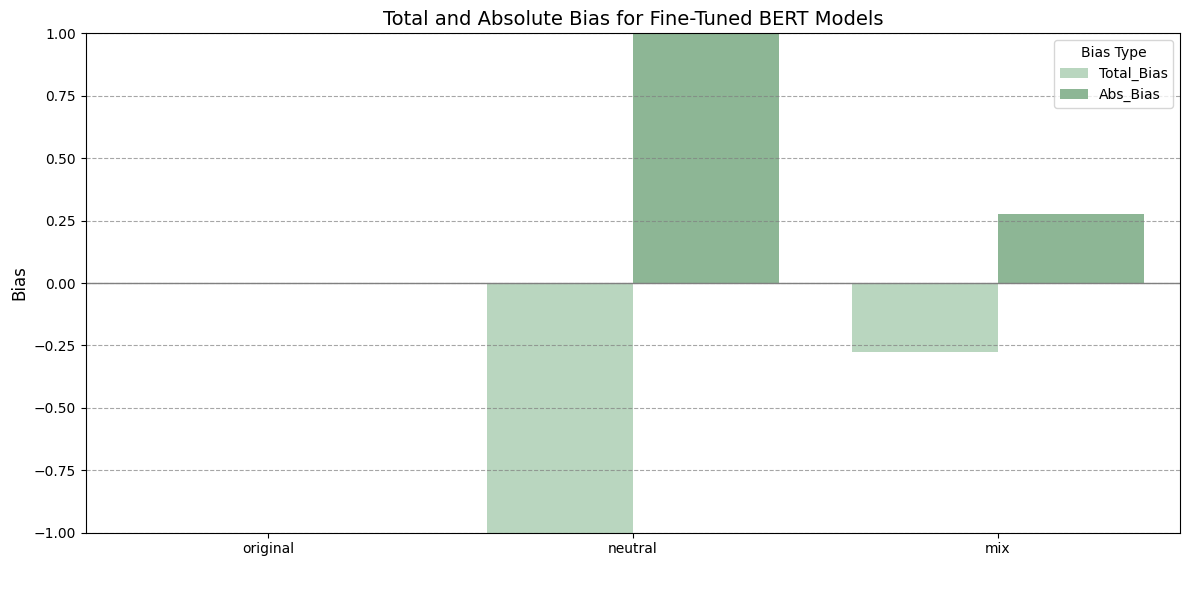

In [131]:
cmap = sns.cubehelix_palette(start = 2, rot = 0, dark = 0.1, light = 0.8) # reverse=True

# Combine the total and abs bias in the same plot
bias_df = bias_df.melt(id_vars = ["Model"],
                        value_vars = ["Total_Bias", "Abs_Bias"],
                        var_name = "Bias_Type",
                        value_name = "Bias_Value")

model_order = ["original", "neutral", "mix"]
bias_df["Model"] = pd.Categorical(bias_df["Model"], categories = model_order, ordered = True)

# Create the plot
plt.figure(figsize = (12, 6))

# Plot both total and abs bias
sns.barplot(data = bias_df, x = "Model", y = "Bias_Value", hue = "Bias_Type", palette = cmap)

# Add horizontal line at y = 0 indicating 0 bias
plt.axhline(0, color = 'gray', linewidth = 1)

# Set y-axis range from -1 to 1
plt.ylim(-1, 1)

# Add labels and title
plt.title('Total and Absolute Bias for Fine-Tuned BERT Models', fontsize = 14)
plt.ylabel('Bias', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

# Display legend and adjust plot
plt.legend(title = "Bias Type", loc = 'upper right')
plt.tight_layout()

# Add horizontal grid lines
plt.grid(True, axis = 'y', linestyle = '--', color = 'gray', alpha = 0.7)

# Show the plot
plt.tight_layout()
plt.show()
